In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Input,LeakyReLU,Dropout,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD,Adam

import numpy as np
import pandas as pd
import os,sys
import matplotlib.pyplot as plt

C:\Users\Noor\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Noor\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Noor\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Noor\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (

In [2]:
mnist  = tf.keras.datasets.mnist

(x_train,y_train),(x_test,y_test) = mnist.load_data()
x_train,x_test = x_train/255.0 * 2 - 1, x_test/255.0 * 2 - 1

In [3]:
x_train.shape

(60000, 28, 28)

In [4]:
N,H,W = x_train.shape
D = H*W
x_train = x_train.reshape(-1,D)
x_test = x_test.reshape(-1,D)

In [5]:
latent_dim = 100

In [6]:
def build_generator(latent_dim):
    i = Input(shape = (latent_dim,))
    x = Dense(256, activation = LeakyReLU(alpha = 0.2))(i)
    x = BatchNormalization(momentum = 0.8)(x)
    x = Dense(512, activation = LeakyReLU(alpha = 0.2))(x)
    x = BatchNormalization(momentum = 0.8)(x)
    x = Dense(1024, activation = LeakyReLU(alpha = 0.2))(x)
    x = BatchNormalization(momentum = 0.8)(x)
    x = Dense(D,activation = "tanh")(x)
    
    model = Model(i,x)
    return model

In [7]:
def build_discriminator(img_size):
    i = Input(shape = (img_size,))
    x = Dense(512, activation = LeakyReLU(alpha = 0.2))(i)
    x = Dense(256, activation = LeakyReLU(alpha = 0.2))(x)
    x = Dense(1, activation = "sigmoid")(x)
    model = Model(i,x)
    return model

In [8]:
#Build and compile the discriminator
discriminator = build_discriminator(D)
discriminator.compile(
    loss = "binary_crossentropy",
    optimizer = Adam(0.0002, 0.5),
    metrics = ["accuracy"])

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
#Build and compile the combined model
generator = build_generator(latent_dim)

#Create an input to represent noise sample from latent space
z = Input(shape = (latent_dim,))

#pass noise through generator to get an image
img = generator(z)

#make sure the generator is trained
discriminator.trainable = False

#The true output is fake but we make them real
fake_pred = discriminator(img)

#Create and combined model object
combined_model = Model(z,fake_pred)

combined_model.compile(loss = "binary_crossentropy", optimizer = Adam(0.0002, 0.5))

In [10]:
batch_size = 32
epochs = 30000
sample_period = 200

ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

d_losses = []
g_losses = []

if not os.path.exists('gan_images'):
    os.makedirs('gan_images')

In [11]:
def sample_images(epoch):
    rows,cols = 5,5
    noise = np.random.randn(rows*cols, latent_dim)
    imgs = generator.predict(noise)
    
    imgs = 0.5 * imgs + 0.5
    
    fig,axes = plt.subplots(rows,cols)
    idx = 0
    for i in range(rows):
        for j in range(cols):
            axes[i,j].imshow(imgs[idx].reshape(H,W), cmap = "gray")
            axes[i,j].axis("off")
            idx+=1
    fig.savefig("gan_images/%d.png" % epoch)
    plt.close()

In [12]:
#Main Training
for epoch in range(epochs):
    #########################
    ###Train Discriminator###
    #########################
    
    #Select a random batch of images
    idx = np.random.randint(0,x_train.shape[0], batch_size)
    real_imgs = x_train[idx]
    
    #Generate fake images
    noise = np.random.randn(batch_size, latent_dim)
    fake_imgs = generator.predict(noise)
    
    #Train the discriminator
    d_loss_real,d_acc_real = discriminator.train_on_batch(real_imgs,ones)
    d_loss_fake,d_acc_fake = discriminator.train_on_batch(fake_imgs,zeros)
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_acc = 0.5 * (d_acc_real + d_acc_fake)
    
    #########################
    #####Train Generator#####
    #########################
    
    noise = np.random.randn(batch_size, latent_dim)
    g_loss = combined_model.train_on_batch(noise,ones)
    
    #Save the losses
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    
    if epoch % 100 == 0:
        print(f"epoch:{epoch+1}/{epochs}, d_loss:{d_loss:.2f},\
        d_acc:{d_acc:.2f},g_loss:{g_loss:.2f}")
        
    if epoch % sample_period == 0:
        sample_images(epoch)

Instructions for updating:
Use tf.cast instead.
epoch:1/30000, d_loss:0.95,        d_acc:0.28,g_loss:0.74
epoch:101/30000, d_loss:0.01,        d_acc:1.00,g_loss:4.51
epoch:201/30000, d_loss:0.02,        d_acc:1.00,g_loss:4.41
epoch:301/30000, d_loss:0.27,        d_acc:0.86,g_loss:3.54
epoch:401/30000, d_loss:0.26,        d_acc:0.95,g_loss:3.07
epoch:501/30000, d_loss:0.74,        d_acc:0.45,g_loss:0.74
epoch:601/30000, d_loss:0.66,        d_acc:0.50,g_loss:0.66
epoch:701/30000, d_loss:0.65,        d_acc:0.66,g_loss:0.73
epoch:801/30000, d_loss:0.65,        d_acc:0.56,g_loss:0.75
epoch:901/30000, d_loss:0.58,        d_acc:0.73,g_loss:0.80
epoch:1001/30000, d_loss:0.63,        d_acc:0.64,g_loss:0.85
epoch:1101/30000, d_loss:0.59,        d_acc:0.70,g_loss:0.88
epoch:1201/30000, d_loss:0.59,        d_acc:0.72,g_loss:0.89
epoch:1301/30000, d_loss:0.58,        d_acc:0.75,g_loss:0.92
epoch:1401/30000, d_loss:0.54,        d_acc:0.80,g_loss:1.04
epoch:1501/30000, d_loss:0.54,        d_acc:0.81,

epoch:12501/30000, d_loss:0.65,        d_acc:0.66,g_loss:1.01
epoch:12601/30000, d_loss:0.55,        d_acc:0.73,g_loss:0.97
epoch:12701/30000, d_loss:0.62,        d_acc:0.64,g_loss:1.02
epoch:12801/30000, d_loss:0.62,        d_acc:0.62,g_loss:0.97
epoch:12901/30000, d_loss:0.60,        d_acc:0.67,g_loss:1.06
epoch:13001/30000, d_loss:0.63,        d_acc:0.61,g_loss:1.01
epoch:13101/30000, d_loss:0.71,        d_acc:0.50,g_loss:0.98
epoch:13201/30000, d_loss:0.62,        d_acc:0.62,g_loss:1.06
epoch:13301/30000, d_loss:0.64,        d_acc:0.66,g_loss:1.09
epoch:13401/30000, d_loss:0.63,        d_acc:0.73,g_loss:1.04
epoch:13501/30000, d_loss:0.70,        d_acc:0.53,g_loss:0.92
epoch:13601/30000, d_loss:0.64,        d_acc:0.58,g_loss:1.05
epoch:13701/30000, d_loss:0.59,        d_acc:0.70,g_loss:1.02
epoch:13801/30000, d_loss:0.64,        d_acc:0.61,g_loss:0.96
epoch:13901/30000, d_loss:0.61,        d_acc:0.69,g_loss:0.95
epoch:14001/30000, d_loss:0.66,        d_acc:0.64,g_loss:1.02
epoch:14

epoch:25801/30000, d_loss:0.63,        d_acc:0.70,g_loss:1.07
epoch:25901/30000, d_loss:0.64,        d_acc:0.64,g_loss:1.12
epoch:26001/30000, d_loss:0.61,        d_acc:0.64,g_loss:1.03
epoch:26101/30000, d_loss:0.72,        d_acc:0.56,g_loss:0.98
epoch:26201/30000, d_loss:0.57,        d_acc:0.70,g_loss:1.09
epoch:26301/30000, d_loss:0.59,        d_acc:0.61,g_loss:0.95
epoch:26401/30000, d_loss:0.58,        d_acc:0.67,g_loss:1.03
epoch:26501/30000, d_loss:0.63,        d_acc:0.61,g_loss:0.97
epoch:26601/30000, d_loss:0.65,        d_acc:0.66,g_loss:0.97
epoch:26701/30000, d_loss:0.60,        d_acc:0.73,g_loss:0.97
epoch:26801/30000, d_loss:0.68,        d_acc:0.56,g_loss:0.98
epoch:26901/30000, d_loss:0.59,        d_acc:0.64,g_loss:0.98
epoch:27001/30000, d_loss:0.59,        d_acc:0.75,g_loss:1.03
epoch:27101/30000, d_loss:0.68,        d_acc:0.53,g_loss:1.08
epoch:27201/30000, d_loss:0.63,        d_acc:0.64,g_loss:0.96
epoch:27301/30000, d_loss:0.63,        d_acc:0.61,g_loss:1.08
epoch:27

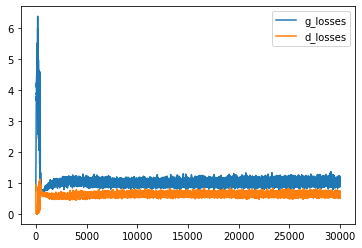

In [13]:
plt.plot(g_losses, label = "g_losses")
plt.plot(d_losses, label = "d_losses")
plt.legend()
plt.show()

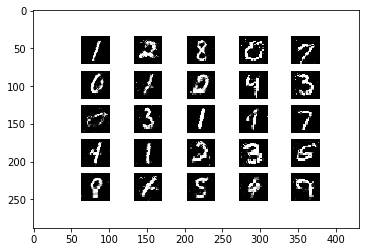

In [23]:
a = plt.imread("gan_images/20000.png")
plt.imshow(a)